In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("uber.csv", nrows=5000)
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [4]:
df = df.drop(['Unnamed: 0','key'], axis=1)
df.dropna(axis=0, inplace=True)
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        5000 non-null   float64
 1   pickup_datetime    5000 non-null   object 
 2   pickup_longitude   5000 non-null   float64
 3   pickup_latitude    5000 non-null   float64
 4   dropoff_longitude  5000 non-null   float64
 5   dropoff_latitude   5000 non-null   float64
 6   passenger_count    5000 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 273.6+ KB


In [6]:
# datetime column is of type object, needs to be datetime
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,11.343850,-72.746112,39.990314,-72.683736,39.998671,1.668800
std,10.744809,13.928678,6.098727,9.875941,6.072471,1.291139
min,2.500000,-748.016667,-73.997740,-75.350437,-73.992137,0.000000
25%,6.000000,-73.992073,40.735023,-73.991370,40.733358,1.000000
50%,8.500000,-73.981540,40.752465,-73.979872,40.752692,1.000000
75%,12.500000,-73.967498,40.766496,-73.963137,40.768382,2.000000
max,350.000000,40.770667,41.366138,40.761672,41.366138,6.000000


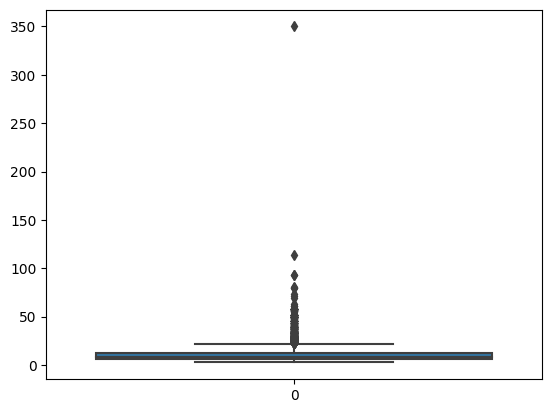

In [8]:
sns.boxplot(df["fare_amount"])
plt.show()

In [9]:
# removing outliers
q_low = df["fare_amount"].quantile(0.01)
q_hi  = df["fare_amount"].quantile(0.99)

df = df[(df["fare_amount"] < q_hi) & (df["fare_amount"] > q_low)]

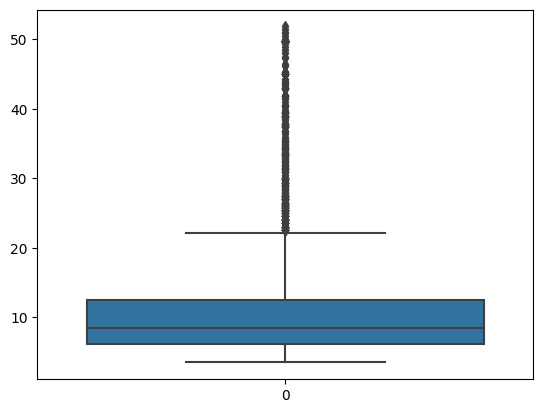

In [10]:
sns.boxplot(df["fare_amount"])
plt.show()

In [11]:
def distance(lon_1, lon_2, lat_1, lat_2):
    lon_1, lon_2, lat_1, lat_2 = map(np.radians, [lon_1, lon_2, lat_1, lat_2])    
    diff_lon = lon_2 - lon_1
    diff_lat = lat_2 - lat_1
    km = 2 * 6371 * np.arcsin(np.sqrt(np.sin(diff_lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lon/2.0)**2))
    return km

In [12]:
df["distance"] = distance(df["pickup_longitude"], df["dropoff_longitude"], df["pickup_latitude"], df["dropoff_latitude"])

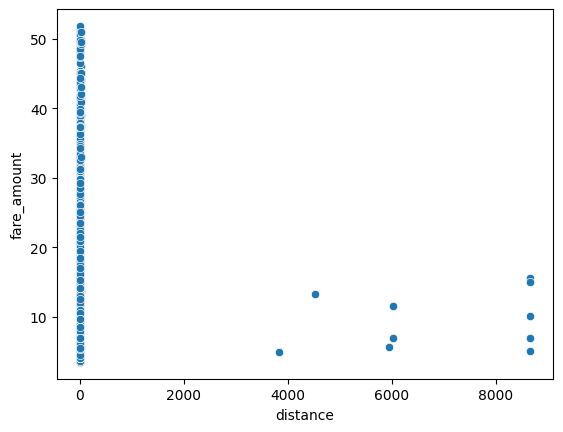

In [13]:
sns.scatterplot(x=df["distance"], y=df["fare_amount"])
plt.show()

In [14]:
# remove large distances and outliers
df.drop(df[df['distance'] > 60].index, inplace = True)
df.drop(df[df['distance'] == 0].index, inplace = True)
df.drop(df[df['fare_amount'] == 0].index, inplace = True)
df.drop(df[df['fare_amount'] < 0].index, inplace = True)
df.drop(df[(df['fare_amount'] > 10) & (df['distance'] < 1)].index, inplace = True )
df.drop(df[(df['fare_amount'] < 10) & (df['distance'] > 10)].index, inplace = True )

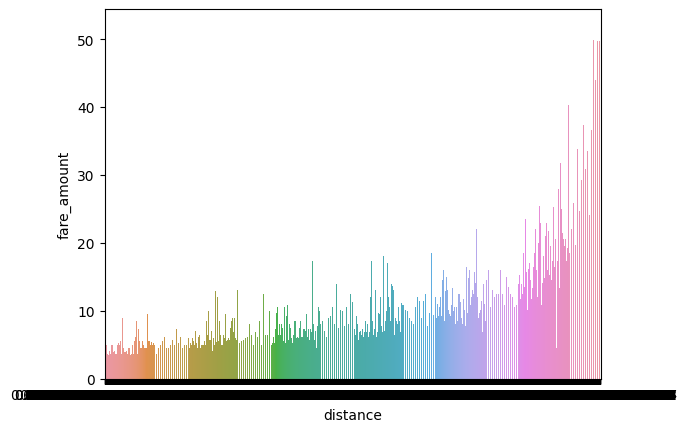

In [15]:
# sns.scatterplot(x=df["distance"], y=df["fare_amount"])
sns.barplot(x=df["distance"],y=df["fare_amount"])
plt.show()


In [16]:
x = df.drop("fare_amount", axis = 1)
x["pickup_datetime"] = pd.to_numeric(x["pickup_datetime"])

y = df["fare_amount"]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

In [18]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predicted = lr_model.predict(x_test)
lr_rmse = np.sqrt(mean_squared_error(lr_predicted, y_test))
print("RMSE value for Linear regression is", lr_rmse)

RMSE value for Linear regression is 7.683393466062252


In [19]:
rfr_model = RandomForestRegressor(n_estimators = 100, random_state = 1)
rfr_model.fit(x_train, y_train)
rfr_prediction = rfr_model.predict(x_test)
rfr_rmse = np.sqrt(mean_squared_error(rfr_prediction, y_test))
print("RMSE value for Random Forest is", rfr_rmse)

RMSE value for Random Forest is 2.8372079996049053
